In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import math
from datetime import datetime

#### Import Kestrel data and change year to 2015

In [2]:
dtypes=[datetime, float]
kes15 = pd.read_excel('Kestrel_data2015.xlsx',names=['time','ws'],header=3)
kes15['time']=kes15['time'].apply((lambda x: x.replace(year=2015)))


#### Import 2015 Sonic data 

In [3]:
son15 = pd.read_csv('2015_sonic_1230_start.txt', sep=",", header=None)
son15.columns = ['u','v','w','sound_speed','temp']

#### Import 2015 Pitot data 

In [4]:
pit15_1 = pd.read_csv('WindTunnelCalibration2015_test1.csv',header=0)
pit15_1.columns = ['time','fan_rpm','air_temp','air_dens','press','ws']
pit15_1['time']=pit15_1['time'].apply((lambda x: pd.to_datetime(x[-5:])))
pit15_1['time']=pit15_1['time'].apply((lambda x: x.replace(year=2015)))
pit15_1['time']=pit15_1['time'].apply((lambda x: x.replace(month=3)))
pit15_1['time']=pit15_1['time'].apply((lambda x: x.replace(day=11)))

In [5]:
pit15_2=pd.read_csv('WindTunnelCalibration2015_test2.csv',header=0)
pit15_2.columns = ['time','fan_rpm','air_temp','air_dens','press','ws']
pit15_2['time']=pit15_2['time'].apply((lambda x: pd.to_datetime(x[-5:])))
pit15_2['time']=pit15_2['time'].apply((lambda x: x.replace(year=2015)))
pit15_2['time']=pit15_2['time'].apply((lambda x: x.replace(month=3)))
pit15_2['time']=pit15_2['time'].apply((lambda x: x.replace(day=11)))

#### Import 2020 Kestrel data 

In [6]:
kes20=pd.read_csv('kestrel_2020.csv',header=0)
kes20.columns = ['time','ws']

#### Import 2020 Sonic data 

In [7]:
son20 = pd.read_csv('sonic_2020.csv', header=None)
son20.columns = ['u','v','w','sound_speed','temp']

#### Plot all the raw timeseries

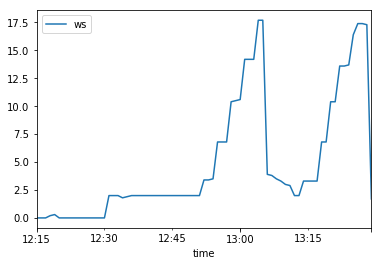

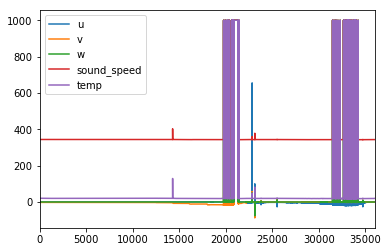

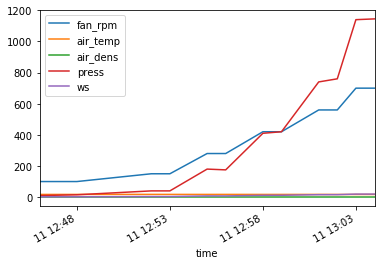

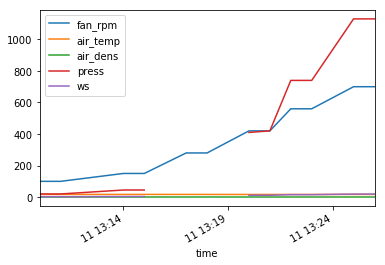

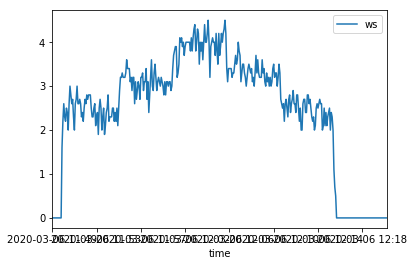

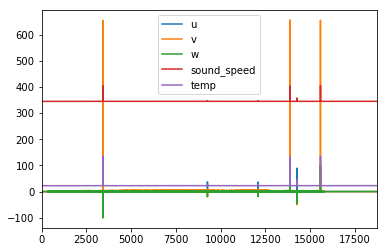

In [8]:
kes15.plot(x='time',y='ws')
son15.plot()
pit15_1.plot(x='time')
pit15_2.plot(x='time')
kes20.plot(x='time',y='ws')
son20.plot()
